In [7]:
import torch
from torch import nn
import os

import sys

sys.path.append("../")
sys.path.append("../../")

from pathlib import Path
import torchvision
import torchvision.transforms as T
from typing import Sequence
from torchvision.transforms import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torchmetrics as TM

from typing import Optional

from torch.utils.data import Dataset

# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()

# Set the working (writable) directory.
working_dir = Path("/Users/fvelikon/projects/mri_cv/data/processed_data_split")

print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print(torch.backends.mps.is_built()) #MPS is activated
torch.cuda.is_available()

USE_MPS = True


True
True


In [8]:
from training.utils import get_device, get_model_parameters, save_model_checkpoint, print_model_parameters, to_device, print_data_in_grid
# Validation: Check if CUDA is available
print(f"CUDA: {torch.cuda.is_available()}")

DEVICE = get_device()
print(f"Device is {DEVICE}")

CUDA: False
Device is mps


# Bimap Legend

<div style="font-size: 20px;">
After subtracting 1 from pixel value.

* 1 = Bone structure (segmentation target)
* 0 = Background pixel
</div>

In [9]:
from training.data import MRIDatasetAugmented, ToDevice

from training.utils import BimapClasses

In [10]:
# Create a tensor for a segmentation trimap.
# Input: Float tensor with values in [0.0 .. 1.0]
# Output: Long tensor with values in {0, 1, 2}
def tensor_bimap(t):
    return t.long()

def args_to_dict(**kwargs):
    return kwargs

transform_dict_train = args_to_dict(
    # pre_transform=T.ToTensor(),
    # pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        ToDevice(get_device()),
        T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
        T.RandomHorizontalFlip(p=0.2),
        T.RandomAffine(degrees=6, scale=(0.8, 1.3)), # NOTE this augmentation hasn't been tested yet
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_bimap),
    ]),
    # post_transform=T.Compose([
    #     T.RandomAdjustSharpness(sharpness_factor=0.9, p=0.1),
    # ]),
)


transform_dict_val_test = args_to_dict(
    # pre_transform=T.ToTensor(),
    # pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        ToDevice(get_device()),
        T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_bimap),
    ]),
    # post_transform=T.Compose([
    #     T.RandomAdjustSharpness(sharpness_factor=0.9, p=0.1),
    # ]),
)

# Create the train and test instances of the data loader for the
# Oxford IIIT Pets dataset with random augmentations applied.
# The images are resized to 128x128 squares, so the aspect ratio
# will be chaged. We use the nearest neighbour resizing algorithm
# to avoid disturbing the pixel values in the provided segmentation
# mask.
images_train = MRIDatasetAugmented(
    root=working_dir,
    split_mode="train",
    target_types="segmentation",
    download=False,
    **transform_dict_train,
)

images_val = MRIDatasetAugmented(
    root=working_dir,
    split_mode="val",
    target_types="segmentation",
    download=False,
    **transform_dict_val_test,
)

images_test = MRIDatasetAugmented(
    root=working_dir,
    split_mode="test",
    target_types="segmentation",
    download=False,
    **transform_dict_val_test,
)

train_loader = torch.utils.data.DataLoader(
    images_train,
    batch_size=64,
    shuffle=True,
)

val_loader = torch.utils.data.DataLoader(
    images_val,
    batch_size=64,
    shuffle=False,
)
test_loader = torch.utils.data.DataLoader(
    images_test,
    batch_size=64,
    shuffle=False,
)




(train_inputs, train_targets) = next(iter(train_loader))
(test_inputs, test_targets) = next(iter(test_loader))
train_inputs.shape, train_targets.shape

(torch.Size([64, 1, 128, 128]), torch.Size([64, 1, 128, 128]))

## Spot check input images and segmentation masks

In [11]:
len(images_val)

70

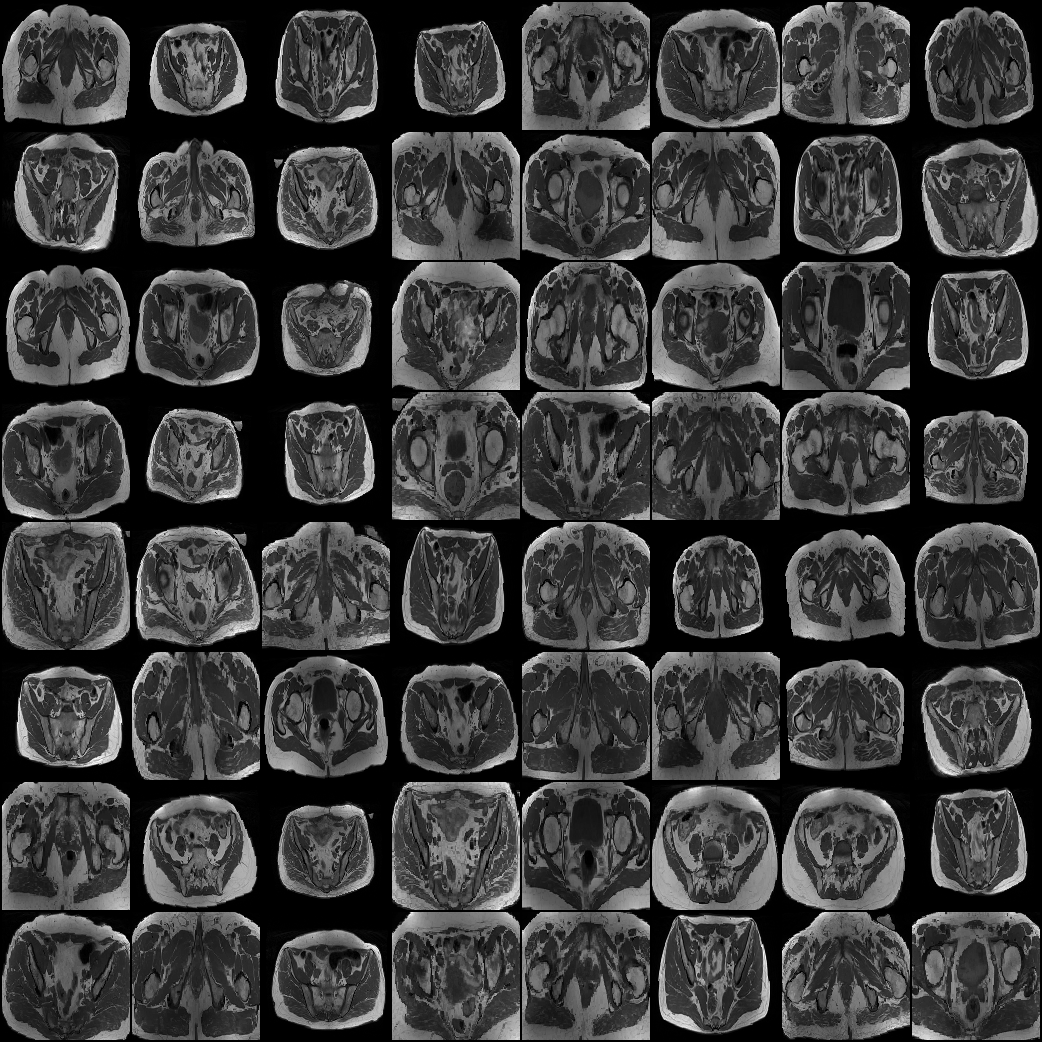

In [12]:
# Let's inspect some of the images.
print_data_in_grid(train_inputs)

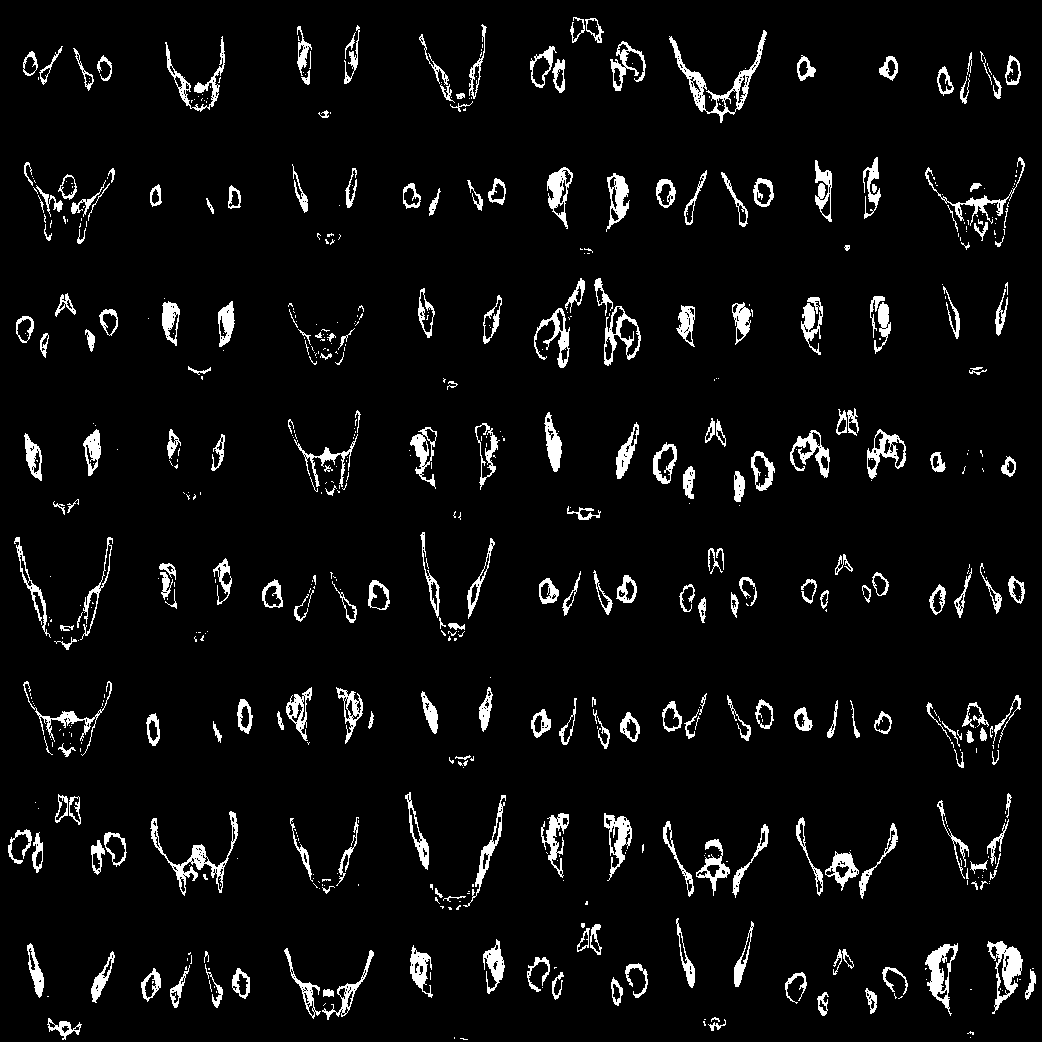

In [13]:
# Let's inspect the segmentation masks corresponding to the images above.
#
# When plotting the segmentation mask, we want to convert the tensor
# into a float tensor with values in the range [0.0 to 1.0]. However, the
# mask tensor has the values (0, 1, 2), so we divide by 2.0 to normalize.
print_data_in_grid(train_targets)

## Neural Network

In [14]:
from models.segnet import SegNet
from models.unet import Unet
from models import ResNet34UnetPlus


In [15]:
# Run the model once on a single input batch to make sure that the model
# runs as expected and returns a tensor with the expected shape.
# m = ImageSegmentation(kernel_size=3)

m = ResNet34UnetPlus(num_channels=1, num_class=2)
m.eval()
to_device(m)
m(to_device(train_inputs).float()).shape

/Users/fvelikon/micromamba/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/fvelikon/micromamba/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/fvelikon/micromamba/envs/ml/lib/python3.10/site-packages/torch/nn/functional.py:4001: UserWarning: MPS: passing scale factor to upsample ops is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/UpSample.mm:246.)
  return torch._C._nn.upsample_nearest2d(input, output_size, sca

torch.Size([64, 2, 128, 128])

## Loss function and custom IOU-loss

In [9]:
from training.metric import IoULoss, IoUMetric

## Model training

In [10]:
from training.utils import plot_inputs_targets_predictions
from training.training import train_model, validate_model

In [11]:
# Train the model for a single epoch

use_cross_entropy = True
if use_cross_entropy:
    criterion = nn.CrossEntropyLoss(reduction='mean')
else:
    criterion = IoULoss(softmax=True)

### Training procedure

In [12]:
# Optimizer and Learning Rate Scheduler.

# Check if our helper functions work as expected and if the image
# is generated as expected.
save_path = Path("../../runs") / "unet_plus_weight_decay_warmup_300_epochs_augs"
save_path.mkdir(exist_ok=True, parents=True)
m = to_device(m)


warmup_epochs = 30
total_epochs = 300

optimizer = torch.optim.Adam(m.parameters(), lr=0.001, weight_decay=1e-6)

step_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=45, gamma=0.7)
warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.05, last_epoch=warmup_epochs)

scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[warmup, step_scheduler], milestones=[warmup_epochs])

In [13]:
# Train our model for 20 epochs, and record the following:
#
# 1. Training Loss
# 2. Test accuracy metrics for a single batch (21 images) of test images. The following
#    metrics are computed:
#   2.1. Pixel Accuracy
#   2.2. IoU Accuracy (weighted)
#   2.3. Custom IoU Accuracy
#
# We also plot the following for each of the 21 images in the validation batch:
# 1. Input image
# 2. Ground truth segmentation mask
# 3. Predicted segmentation mask
#
# so that we can visually inspect the model's progres and determine how well the model
# is doing qualitatively. Note that the validation metrics on the set of 21 images in
# the validation set is displayed inline in the notebook only for the last training
# epoch.
#

model, train_report = train_model(
    model=m, train_loader=train_loader, eval_loader=val_loader, test_loader=test_loader,
    optimizer=optimizer, num_epochs=total_epochs, criterion=criterion, device=DEVICE,
    use_cross_entropy=use_cross_entropy, save_path=save_path,
    scheduler=scheduler,
)

[TRAIN]:   0%|          | 0/300 [00:00<?, ?it/s]

/Users/fvelikon/micromamba/envs/ml/lib/python3.10/site-packages/torch/functional.py:905: UserWarning: MPS: _unique2 op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performace implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Unique.mm:323.)
  output, inverse_indices, counts = torch._unique2(
/Users/fvelikon/micromamba/envs/ml/lib/python3.10/site-packages/torchmetrics/functional/classification/accuracy.py:77: UserWarning: MPS: no support for int64 for sum_out_mps, downcasting to a smaller data type (int32/float32). Native support for int64 has been added in macOS 13.3. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:155.)
  tp = tp.sum(dim=0 if multidim_average == "global" else 1)


[VAL] Epoch: 1, Loss: 580.8105, Accuracy[Pixel: 0.0452, IoU: 1.0000, Custom IoU: 0.0234]
[VAL] Epoch: 2, Loss: 64556.8594, Accuracy[Pixel: 0.0449, IoU: 1.0000, Custom IoU: 0.0231]
[VAL] Epoch: 3, Loss: 13953.5850, Accuracy[Pixel: 0.0457, IoU: 1.0000, Custom IoU: 0.0235]
[VAL] Epoch: 4, Loss: 115.8580, Accuracy[Pixel: 0.1834, IoU: 0.9985, Custom IoU: 0.1025]
[VAL] Epoch: 5, Loss: 11.0882, Accuracy[Pixel: 0.9551, IoU: 0.0000, Custom IoU: 0.9112]
[VAL] Epoch: 6, Loss: 4.4570, Accuracy[Pixel: 0.9551, IoU: 0.0000, Custom IoU: 0.9060]
[VAL] Epoch: 7, Loss: 1.5314, Accuracy[Pixel: 0.9551, IoU: 0.0000, Custom IoU: 0.8954]
[VAL] Epoch: 8, Loss: 0.3942, Accuracy[Pixel: 0.9551, IoU: 0.0000, Custom IoU: 0.8889]
[VAL] Epoch: 9, Loss: 0.2655, Accuracy[Pixel: 0.9551, IoU: 0.0000, Custom IoU: 0.8959]
[VAL] Epoch: 10, Loss: 0.2433, Accuracy[Pixel: 0.9551, IoU: 0.0000, Custom IoU: 0.9031]
[VAL] Epoch: 11, Loss: 0.2479, Accuracy[Pixel: 0.9551, IoU: 0.0000, Custom IoU: 0.9064]
[VAL] Epoch: 12, Loss: 0.248

/Users/fvelikon/micromamba/envs/ml/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[VAL] Epoch: 31, Loss: 0.0889, Accuracy[Pixel: 0.9630, IoU: 0.3919, Custom IoU: 0.9014]
[VAL] Epoch: 32, Loss: 0.0902, Accuracy[Pixel: 0.9646, IoU: 0.3911, Custom IoU: 0.9114]
[VAL] Epoch: 33, Loss: 0.0937, Accuracy[Pixel: 0.9630, IoU: 0.2991, Custom IoU: 0.9119]
[VAL] Epoch: 34, Loss: 0.0887, Accuracy[Pixel: 0.9618, IoU: 0.5009, Custom IoU: 0.8999]
[VAL] Epoch: 35, Loss: 0.0957, Accuracy[Pixel: 0.9601, IoU: 0.3124, Custom IoU: 0.9004]
[VAL] Epoch: 36, Loss: 0.0933, Accuracy[Pixel: 0.9622, IoU: 0.3378, Custom IoU: 0.9058]
[VAL] Epoch: 37, Loss: 0.0885, Accuracy[Pixel: 0.9626, IoU: 0.4998, Custom IoU: 0.9022]
[VAL] Epoch: 38, Loss: 0.0873, Accuracy[Pixel: 0.9645, IoU: 0.3841, Custom IoU: 0.9152]
[VAL] Epoch: 39, Loss: 0.0903, Accuracy[Pixel: 0.9639, IoU: 0.3237, Custom IoU: 0.9164]
[VAL] Epoch: 40, Loss: 0.0855, Accuracy[Pixel: 0.9652, IoU: 0.4844, Custom IoU: 0.9145]
[VAL] Epoch: 41, Loss: 0.0991, Accuracy[Pixel: 0.9618, IoU: 0.2353, Custom IoU: 0.9149]
[VAL] Epoch: 42, Loss: 0.0865, A

In [14]:
import plotly.express as px

In [15]:
px.line(y=[train_report["train_losses"], train_report["val_losses"]])

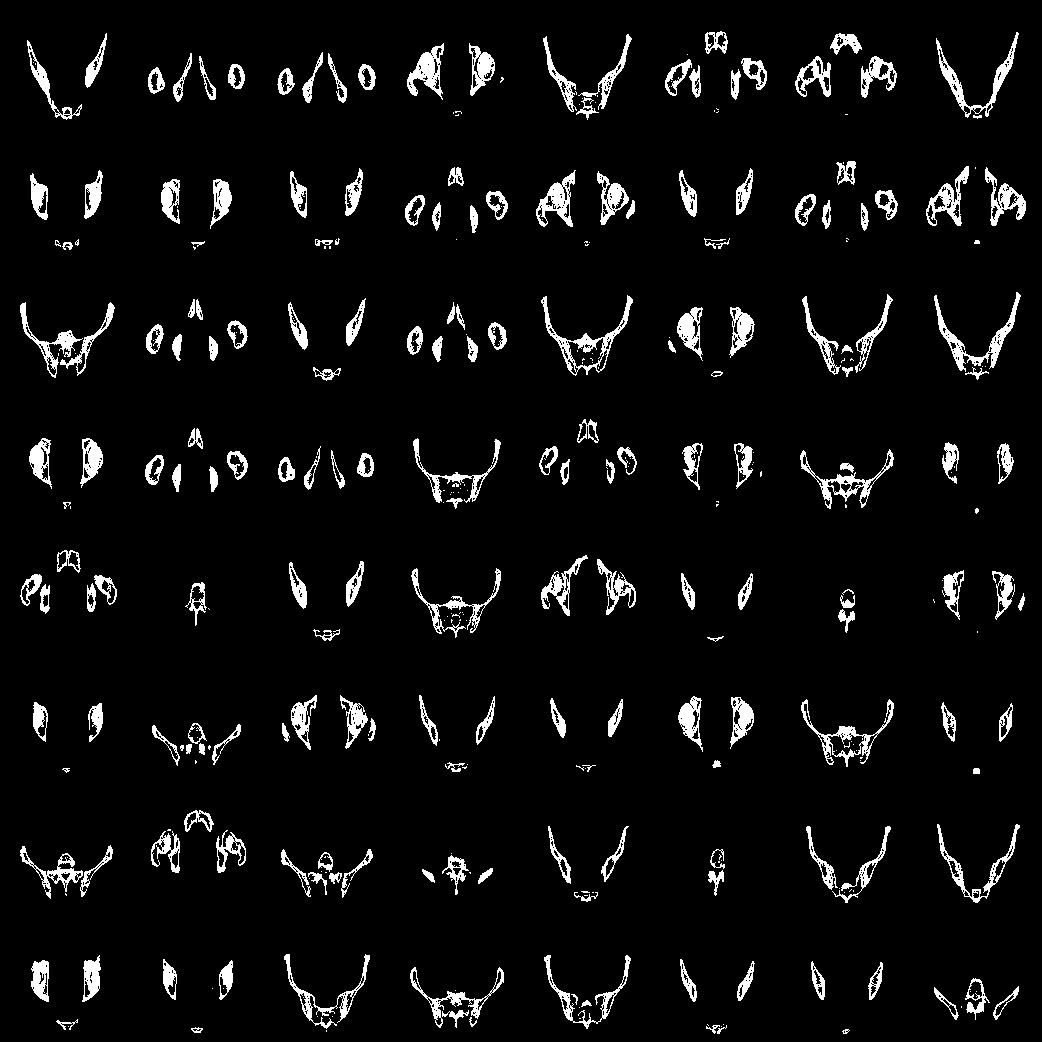

In [50]:
targets_grid = torchvision.utils.make_grid(test_targets.float(), nrow=8).cpu()
t2img(targets_grid)

In [51]:
m.load_state_dict(state_dict=torch.load("/Users/fvelikon/projects/mri_cv/runs/unet_plus_weight_decay_warmup_300_epochs_augs/last.pth", map_location="mps"))



<All keys matched successfully>

In [52]:
predict = m(test_inputs).softmax(1).argmax(1, keepdims=True).float()
predict.shape

torch.Size([64, 1, 128, 128])

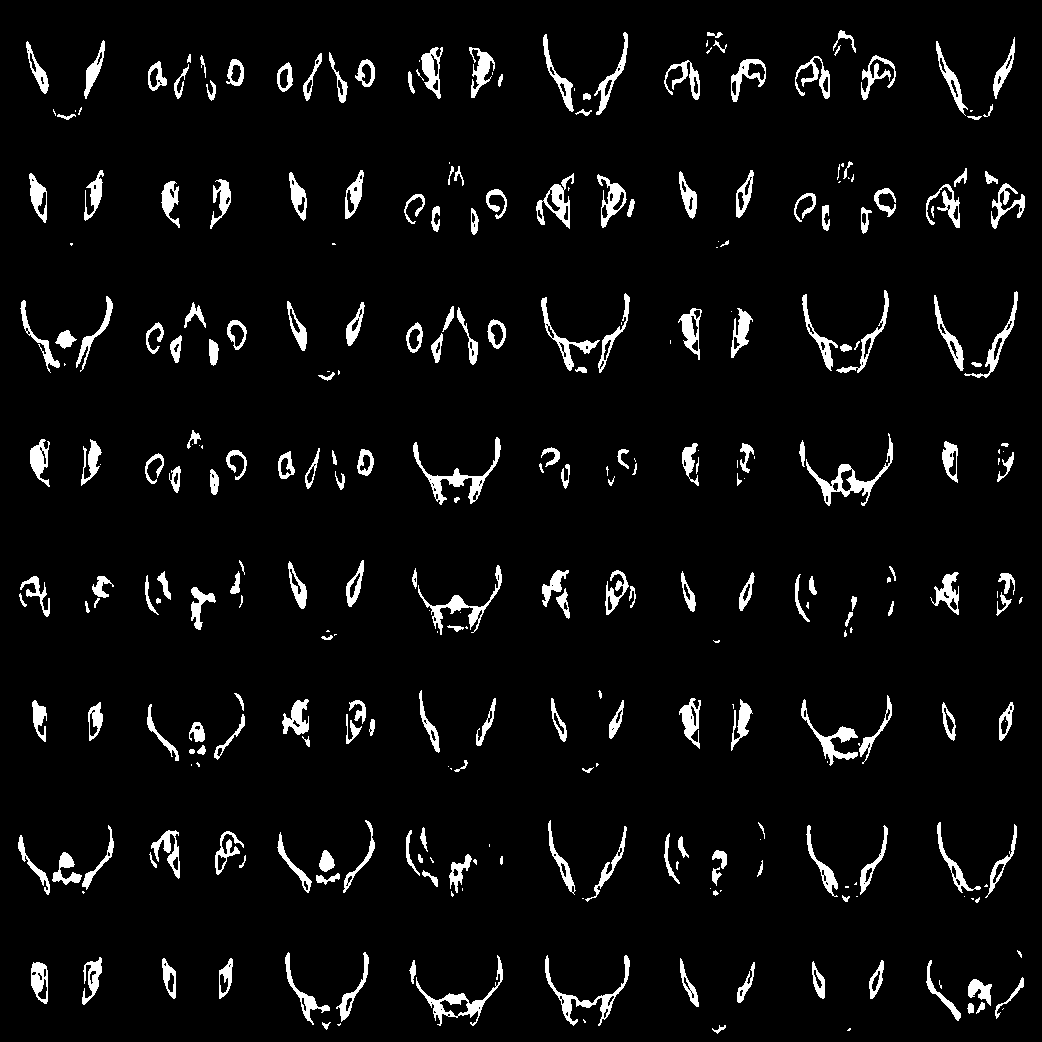

In [53]:
predicts_grid = torchvision.utils.make_grid(predict, nrow=8).cpu()

t2img(predicts_grid)

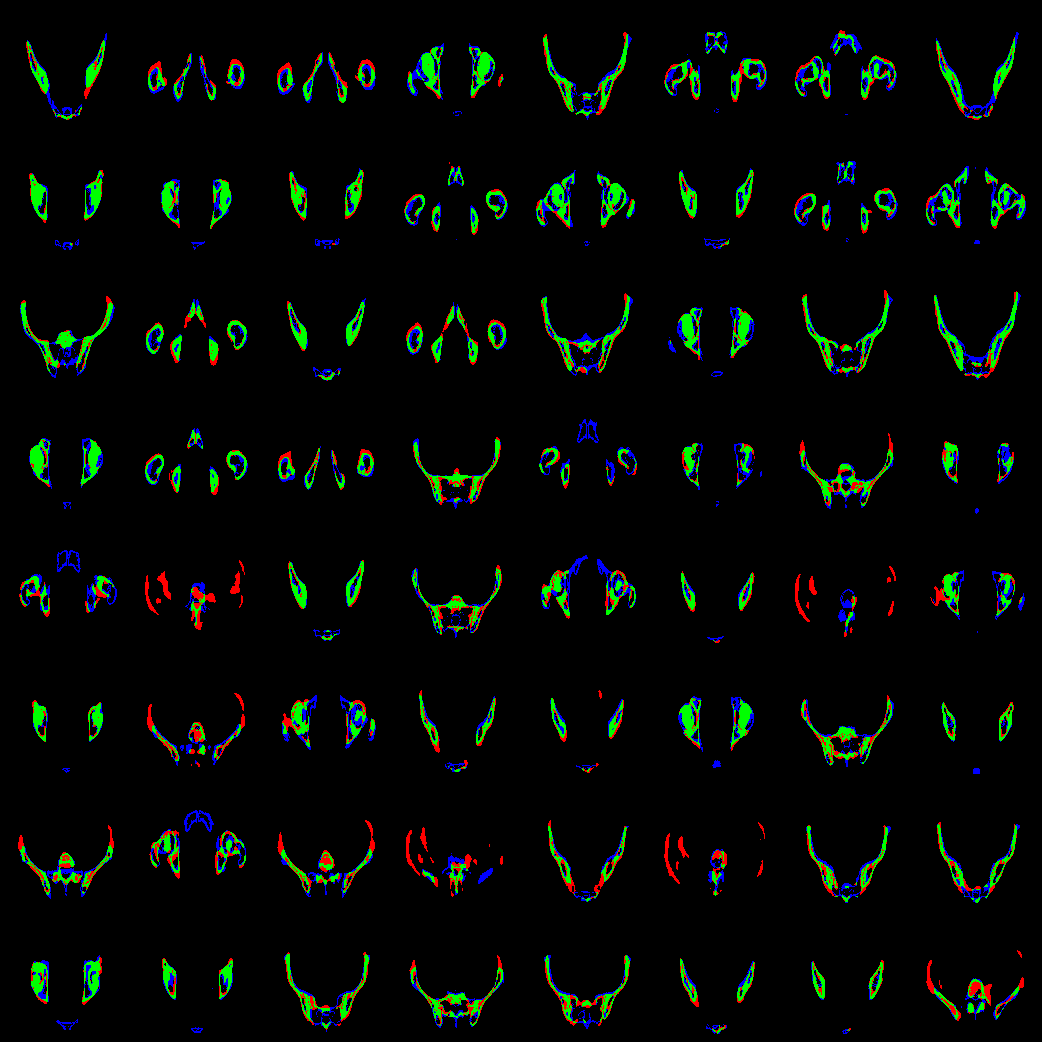

In [67]:
diff_grid = torch.zeros_like(targets_grid)


ground_truth = targets_grid[0, ...].long()
predictions = predicts_grid[0, ...].long()

FP_MASK = ((predictions == 1) * (ground_truth == 0))
FN_MASK = ((predictions == 0) * (ground_truth == 1))
TP_MASK = ((predictions == 1) * (ground_truth == 1))



diff_grid = diff_grid.permute(1, 2, 0)

diff_grid[TP_MASK] = torch.FloatTensor([0, 1, 0])
diff_grid[FP_MASK] = torch.FloatTensor([1, 0, 0])
diff_grid[FN_MASK] = torch.FloatTensor([0, 0, 1])

diff_grid = diff_grid.permute(2, 0, 1)


t2img(diff_grid)

Generate gif for existing runs

In [19]:
# from training.utils import create_gif_from_images
# runs_roots = [
#     Path("/Users/fvelikon/projects/mri_cv/runs/unet_70_epochs"),
#     Path("/Users/fvelikon/projects/mri_cv/runs/unet_plus_weight_decay_warmup_100_epochs_augs"),
#     Path("/Users/fvelikon/projects/mri_cv/runs/unet_weight_decay"),
#     Path("/Users/fvelikon/projects/mri_cv/runs/unet_weight_decay_warmup_100_epochs_augs"),
#     Path("/Users/fvelikon/projects/mri_cv/runs/unet_weight_decay_lr001")
    
# ]


# for run_root in runs_roots:
    
#     for split in ["TRAIN", "VAL"]:
        
#         images_dir = run_root / split
#         gif_name = run_root / f"{split}_epochs.gif"
        
#         try:
            
#             create_gif_from_images(images_dir=images_dir, gif_path_name=gif_name)
            
#         except IndexError:
#             pass